In [4]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime

In [26]:
import matplotlib.pyplot as plt

In [29]:
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

In [20]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [55]:
def sMAPE(a, b):
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

In [35]:
'''
https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
'''

In [61]:
folder = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/datasets/finales/"
filename = "affluent_std.csv"
df = read_csv(folder + filename,parse_dates = ['hour'], index_col = ['hour'])
df = df.rename(columns={"energy(kWh/hh)": "energy"})

In [62]:
df.head()

,energy
hour,
2012-01-01 00:00:00,0.234250
2012-01-01 00:30:00,0.213458
2012-01-01 01:00:00,0.236750
2012-01-01 01:30:00,0.207667
2012-01-01 02:00:00,0.193708


In [84]:
dataset = df.energy.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = 32112
test_size = 2928
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 500
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [85]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=50, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 31611 samples, validate on 2427 samples
Epoch 1/30
31611/31611 [==============================] - 4s 137us/step - loss: 0.0037 - val_loss: 0.0263
Epoch 2/30
31611/31611 [==============================] - 4s 113us/step - loss: 0.0025 - val_loss: 0.0298
Epoch 3/30
31611/31611 [==============================] - 8s 252us/step - loss: 0.0026 - val_loss: 0.0224
Epoch 4/30
31611/31611 [==============================] - 11s 357us/step - loss: 0.0025 - val_loss: 0.0193
Epoch 5/30
31611/31611 [==============================] - 11s 354us/step - loss: 0.0025 - val_loss: 0.0166
Epoch 6/30
31611/31611 [==============================] - 10s 331us/step - loss: 0.0024 - val_loss: 0.0150
Epoch 7/30
31611/31611 [==============================] - 8s 266us/step - loss: 0.0023 - val_loss: 0.0134
Epoch 8/30
31611/31611 [==============================] - 12s 375us/step - loss: 0.0022 - val_loss: 0.0124
Epoch 9/30
31611/31611 [==============================] - 6s 177us/step - loss: 0.0021 - val_loss: 

In [86]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
print(sMAPE(Y_test,test_predict))

Train Mean Absolute Error: 0.02863146967189879
Train Root Mean Squared Error: 0.040208355776966985
Test Mean Absolute Error: 0.031208803022543998
Test Root Mean Squared Error: 0.03928544673557166
11.893684798110147


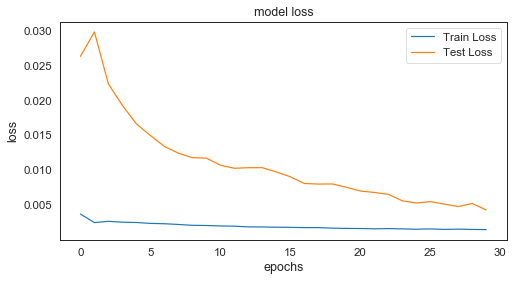

In [87]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

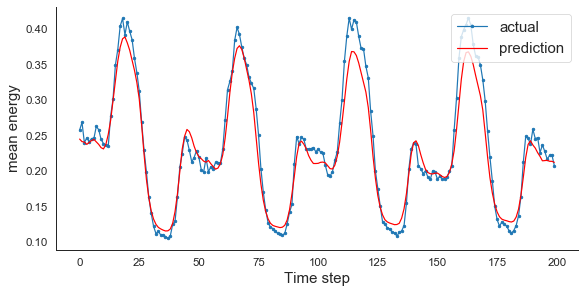

In [89]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('mean energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();